# Random Forest Classifier

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Law of Large Number

In [2]:
heads_prob = 0.51
coin_toss = (np.random.rand(10000, 10) < heads_prob).astype(np.int32)

In [8]:
cumulative_heads_ratio = np.cumsum(coin_toss, axis = 0)/np.arange(1, 10001).reshape(-1, 1)

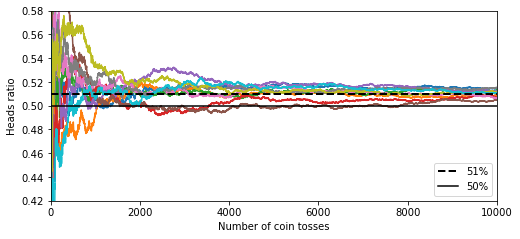

In [10]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [21]:
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', probability=True, random_state=42)
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
                             voting='hard')

In [22]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))])

In [23]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


If all classifiers estimates probabilities, we can tell sklearn to predict the class with the highest class probabilities, averaged over all individual classifiers. This is called *Soft voting*, and often achieves higher performance than hard voting because it gives more weight to highly confident votes.

## - Soft Voting

In [24]:
soft_voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
                             voting='soft')
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, soft_voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 2. Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set. When sampling is performed with replacement, it is known as *bagging* (bootstrap aggregating). When sampling is performed without replacement, it is called pasting.

BaggingClassifier automatically performs soft voting if the base classifier can estimate class probabilities

In [30]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

## Train an emsemble of 500 classifiers, each on 100 samples with replacement (bootstrap=True)
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                          max_samples=100, bootstrap=True, random_state=42, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [31]:
accuracy_score(y_test, y_pred)

0.904

In [36]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [37]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

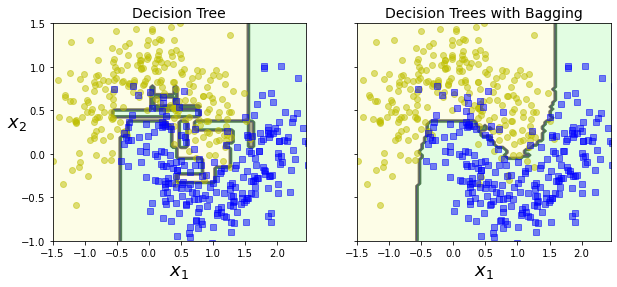

In [38]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

The above compares the decision boundary of a single Decision Tree with the decision
boundary of a bagging ensemble of 500 trees (from the preceding code), both
trained on the moons dataset. As you can see, the ensemble’s predictions will likely
generalize much better than the single Decision Tree’s predictions: the ensemble has a
comparable bias but a smaller variance (it makes roughly the same number of errors
on the training set, but the decision boundary is less irregular).

In [40]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                           bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8933333333333333

In [41]:
accuracy_score(y_test, bag_clf.predict(X_test))

0.912

In [45]:
# bag_clf.oob_decision_function_

- ### Random Patches
> Sampling both training instances and features

- ### Random Subspace
> Keeping all training instances but sampling features

## 3. Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

#### - Feature Importance

- Iris Dataset

In [51]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10502315998783249
sepal width (cm) 0.02296445438259781
petal length (cm) 0.4409755664802367
petal width (cm) 0.43103681914933295


- MINST Dataset

In [54]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [55]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [58]:
import matplotlib as mpl
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

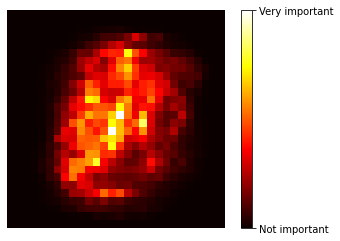

In [59]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

## Gradient Boosting

In [60]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [62]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

- Early stopping

In [66]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

In [71]:
bst_n_estimators = np.argmin(errors) + 1
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=75, random_state=42)

In [72]:
min_error = np.min(errors)

## Exercise - 8

Load the MNIST data (introduced in Chapter 3), and split it into a training set, a
validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation,
and 10,000 for testing). Then train various classifiers, such as a Random
Forest classifier, an Extra-Trees classifier, and an SVM. Next, try to combine
them into an ensemble that outperforms them all on the validation set, using a
soft or hard voting classifier. Once you have found one, try it on the test set. How
much better does it perform compared to the individual classifiers?

In [76]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [78]:
from sklearn.model_selection import train_test_split

X, y = mnist["data"], mnist["target"]

In [79]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=0.7, random_state=42)

In [82]:
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, train_size=0.5, random_state=42)

### - Individual Classifiers

In [84]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
ex_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)
estimators = [rnd_clf, ex_clf, svm_clf, mlp_clf] ## List of classifiers

In [85]:
for estimator in estimators:
    print("Training the ", estimator)
    estimator.fit(X_train, y_train)

Training the  RandomForestClassifier(random_state=42)
Training the  ExtraTreesClassifier(random_state=42)
Training the  LinearSVC(max_iter=100, random_state=42, tol=20)
Training the  MLPClassifier(random_state=42)


In [86]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9667619047619047, 0.9686666666666667, 0.8747619047619047, 0.960952380952381]

### - Ensemble

In [87]:
from sklearn.ensemble import VotingClassifier

In [90]:
named_estimators = [
    ("random_forest_clf", rnd_clf),
    ("extra_trees_clf", ex_clf),
    ("SVM_clf", svm_clf),
    ("MLP_clf", mlp_clf),
]

In [112]:
voting_clf = VotingClassifier(estimators=named_estimators)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('SVM_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('MLP_clf', MLPClassifier(random_state=42))])

In [94]:
voting_clf.score(X_val, y_val)

0.968

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to None using set_params() like this:

In [115]:
voting_clf.set_params(SVM_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('SVM_clf', None),
                             ('MLP_clf', MLPClassifier(random_state=42))])

This updated the list of estimators:

In [116]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('SVM_clf', None),
 ('MLP_clf', MLPClassifier(random_state=42))]

However, it did not update the list of trained estimators:

In [117]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

So we can either fit the VotingClassifier again, or just remove the SVM from the list of trained estimators:

In [118]:
del voting_clf.estimators_[2]

In [119]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 MLPClassifier(random_state=42)]

In [120]:
voting_clf.score(X_val, y_val)

0.971047619047619

The performance slightly improved, SVM was hurting performance. Now let's try soft voting.

In [121]:
voting_clf.voting = "soft"

In [122]:
voting_clf.score(X_val, y_val)

0.9655238095238096

In [123]:
voting_clf.voting = "hard"

In [124]:
voting_clf.score(X_test, y_test)

0.9715238095238096

In [125]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.0, 0.0, 0.0]

---

## Exercise - Stacking ensembles

Run the individual classifiers from the previous exercise to make predictions on
the validation set, and create a new training set with the resulting predictions:
each training instance is a vector containing the set of predictions from all your
classifiers for an image, and the target is the image’s class. Train a classifier on
this new training set. Congratulations, you have just trained a blender, and
together with the classifiers they form a stacking ensemble! Now let’s evaluate the
ensemble on the test set. For each image in the test set, make predictions with all
your classifiers, then feed the predictions to the blender to get the ensemble’s

In [126]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
ex_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
mlp_clf = MLPClassifier(random_state=42)
estimators = [rnd_clf, ex_clf, mlp_clf] ## List of classifiers

In [135]:
[estimator.fit(X_train, y_train) for estimator in estimators]

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 MLPClassifier(random_state=42)]

In [136]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

In [137]:
for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [140]:
X_val_predictions

array([[3., 3., 3.],
       [6., 6., 6.],
       [8., 8., 8.],
       ...,
       [3., 3., 3.],
       [7., 7., 7.],
       [0., 0., 0.]], dtype=float32)

In [141]:
rnd_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [142]:
rnd_blender.oob_score_

0.967047619047619

In [143]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

In [144]:
for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [145]:
accuracy_score(y_test, rnd_blender.predict(X_test_predictions))

0.9673333333333334